In [233]:
!kaggle competitions download -c learn-ai-bbc

learn-ai-bbc.zip: Skipping, found more recently modified local copy (use --force to force download)


In [234]:
!cp kaggle.json ~/.kaggle/

In [235]:
!chmod 600 /Users/alicesum/.kaggle/kaggle.json

In [236]:
!kaggle competitions download -c learn-ai-bbc

learn-ai-bbc.zip: Skipping, found more recently modified local copy (use --force to force download)


In [237]:
import zipfile
import os
!mkdir "data"
!mkdir "data/bbc"
zip_path = 'learn-ai-bbc.zip'
extract_path = 'data/bbc'  # Optional: Specify a target directory
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)  # Extracts to the specified path

mkdir: data: File exists
mkdir: data/bbc: File exists


In [238]:
!pip install pandas

In [239]:
import pandas as pd

In [240]:
df = pd.read_csv('data/bbc/BBC News Train.csv')
df.head()

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


In [241]:
import pandas as pd

In [242]:
from sklearn.feature_extraction.text import TfidfVectorizer


Extracting word features and show Exploratory Data Analysis (EDA) 

We can see the dataset has 3 columns. They are articled, text, and category.

I will remove the Articled for the train as it is useless because it is not related to the text.

In [243]:
df

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business
...,...,...,...
1485,857,double eviction from big brother model caprice...,entertainment
1486,325,dj double act revamp chart show dj duo jk and ...,entertainment
1487,1590,weak dollar hits reuters revenues at media gro...,business
1488,1587,apple ipod family expands market apple has exp...,tech


In [244]:
categories = df['Category'].str.get_dummies(sep=',')

In [245]:
categories

,business,entertainment,politics,sport,tech
0,1,0,0,0,0
1,1,0,0,0,0
2,1,0,0,0,0
3,0,0,0,0,1
4,1,0,0,0,0
...,...,...,...,...,...
1485,0,1,0,0,0
1486,0,1,0,0,0
1487,1,0,0,0,0
1488,0,0,0,0,1


In [246]:
df

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business
...,...,...,...
1485,857,double eviction from big brother model caprice...,entertainment
1486,325,dj double act revamp chart show dj duo jk and ...,entertainment
1487,1590,weak dollar hits reuters revenues at media gro...,business
1488,1587,apple ipod family expands market apple has exp...,tech


In [247]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df['Category'])

In [248]:
df['Category'].unique()

array(['business', 'tech', 'politics', 'sport', 'entertainment'],
      dtype=object)

In [249]:
df['Category'] = df['Category'].apply(lambda x: x[0] if isinstance(x, list) else x)

# Now apply MultiLabelBinarizer (should give 5 columns)
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df['Category'].values.reshape(-1, 1))  # Reshape for single-label
print("Classes:", mlb.classes_)  # Should output ['business', 'tech', ...]
print("Shape of y:", y.shape)    # Should be (n_samples, 5)

Classes: ['business' 'entertainment' 'politics' 'sport' 'tech']
Shape of y: (1490, 5)


In [250]:
df['Category'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 1490 entries, 0 to 1489
Series name: Category
Non-Null Count  Dtype 
--------------  ----- 
1490 non-null   object
dtypes: object(1)
memory usage: 11.8+ KB


In [251]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import Normalizer

In [252]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.pipeline import Pipeline

def nmf_pipeline(max_features=1000, max_components=10):
    """Creates a pipeline that automatically handles NMF initialization"""
    tfidf = TfidfVectorizer(
        stop_words='english',
        max_features=max_features,
        min_df=2,
        max_df=0.8
    )
    
    # First transform to get dimensions
    temp_pipe = Pipeline([('tfidf', tfidf)])
    X_temp = temp_pipe.fit_transform(df['Text'])
    
    # Calculate safe number of components
    n_samples, n_features = X_temp.shape
    n_components = min(max_components, n_samples, n_features)
    print(f'suggested n_components: {n_components}')
    # Choose initialization method
    init_method = 'nndsvd' if n_components <= min(n_samples, n_features) else 'random'
    
    # return Pipeline([
    #     ('tfidf', tfidf),
    #     ('nmf', NMF(
    #         n_components=n_components,
    #         init='random',
    #         beta_loss='frobenius',
    #         solver='mu',
    #         max_iter=500,
    #     ))
    # ])
    p =Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=10000,          # Limit vocabulary size
        sublinear_tf=True,           # Smooth term frequencies
        min_df=5,                    # Ignore rare words
        max_df=0.95,                 # Ignore overly common words
        stop_words='english'         # Remove stopwords
    )),
    
    ('normalizer', Normalizer()),    # Scale features without breaking sparsity
    
    ('nmf', NMF(
        n_components=n_components,             # Reduced dimensions
        init='nndsvda',              # Better zero handling
        solver='mu',                 # Multiplicative update
        beta_loss='kullback-leibler', # More suitable for text
        random_state=42,
        max_iter=200
    )),
    
    ('clf', OneVsRestClassifier(
        LogisticRegression(
            solver='saga',           # Handles sparse data better
            penalty='l1',            # Works well with text features
            C=0.5,                  # Stronger regularization
            max_iter=500,
            random_state=42
        )
    ))
    ])
    return p
# Create safe pipeline
pipeline = nmf_pipeline(max_components=5)

suggested n_components: 5


In [253]:
df

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business
...,...,...,...
1485,857,double eviction from big brother model caprice...,entertainment
1486,325,dj double act revamp chart show dj duo jk and ...,entertainment
1487,1590,weak dollar hits reuters revenues at media gro...,business
1488,1587,apple ipod family expands market apple has exp...,tech


In [254]:
df.head()

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


In [255]:
categories

,business,entertainment,politics,sport,tech
0,1,0,0,0,0
1,1,0,0,0,0
2,1,0,0,0,0
3,0,0,0,0,1
4,1,0,0,0,0
...,...,...,...,...,...
1485,0,1,0,0,0
1486,0,1,0,0,0
1487,1,0,0,0,0
1488,0,0,0,0,1


Building and training models, and split it

In [ ]:
# Split data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df['Text'], y, test_size=0.25, random_state=42
)

Building and training models. 

In [257]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer

# Stable text classification pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=5000,          # Reduced vocabulary size
        min_df=10,                  # Filter rare terms
        max_df=0.8,                # Filter overly common terms
        ngram_range=(1, 2),        # Include bigrams
        sublinear_tf=True,          # Smooth term frequencies
        stop_words='english'        # Remove stopwords
    )),
    ('normalizer', Normalizer(norm='l2')),  # Essential for stability
    ('clf', OneVsRestClassifier(
        SGDClassifier(
            loss='log_loss',        # Correct loss function
            penalty='l2',           # More stable than l1
            alpha=1e-4,             # Regularization strength
            max_iter=1000,
            early_stopping=True,
            validation_fraction=0.1,
            n_iter_no_change=5,
            random_state=42,
            class_weight='balanced'  # Handle imbalanced classes
        )
    ))
])

# Training with stability checks
try:
    pipeline.fit(X_train, y_train)
    train_score = pipeline.score(X_train, y_train)
    test_score = pipeline.score(X_test, y_test)
    print(f"Train accuracy: {train_score:.4f}")
    print(f"Test accuracy: {test_score:.4f}")
except Exception as e:
    print(f"Training failed: {str(e)}")

Train accuracy: 0.9964
Test accuracy: 0.9651


In [258]:
from sklearn.decomposition import MiniBatchNMF

nmf = MiniBatchNMF(
    n_components=5,
    init='random',  # MiniBatchNMF doesn't support nndsvd
    random_state=42,
    batch_size=128
)

In [259]:
categories

,business,entertainment,politics,sport,tech
0,1,0,0,0,0
1,1,0,0,0,0
2,1,0,0,0,0
3,0,0,0,0,1
4,1,0,0,0,0
...,...,...,...,...,...
1485,0,1,0,0,0
1486,0,1,0,0,0
1487,1,0,0,0,0
1488,0,0,0,0,1


In [260]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (confusion_matrix, roc_curve, auc, 
                            accuracy_score, classification_report)

In [261]:
df

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business
...,...,...,...
1485,857,double eviction from big brother model caprice...,entertainment
1486,325,dj double act revamp chart show dj duo jk and ...,entertainment
1487,1590,weak dollar hits reuters revenues at media gro...,business
1488,1587,apple ipod family expands market apple has exp...,tech


In [262]:
print(df['Category'].unique())

['business' 'tech' 'politics' 'sport' 'entertainment']


Accuracy: 0.9651



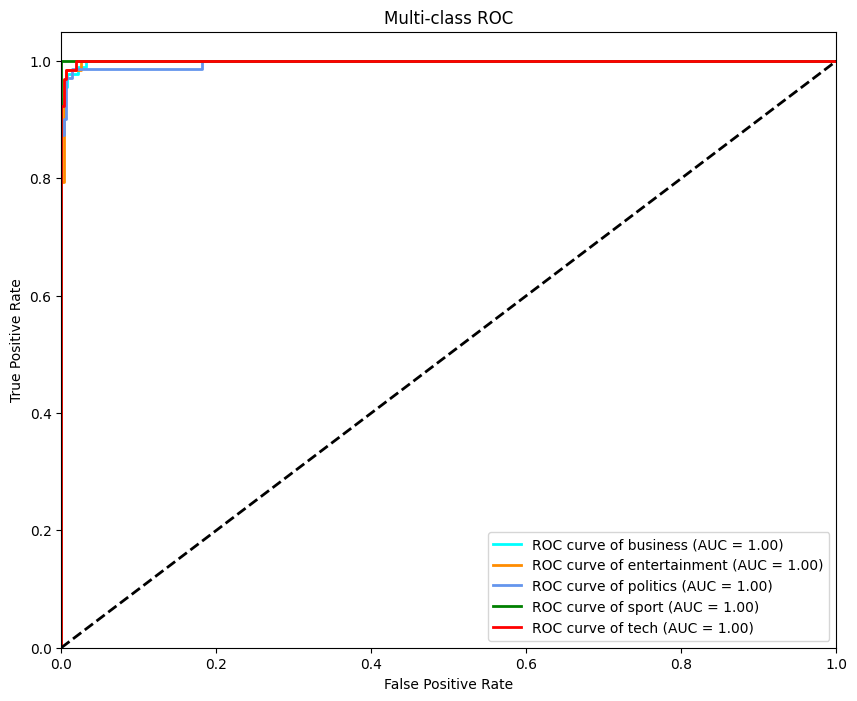

               precision    recall  f1-score   support

     business       0.99      0.96      0.97        92
entertainment       0.97      0.98      0.98        63
     politics       0.97      0.97      0.97        71
        sport       0.99      1.00      0.99        81
         tech       0.97      0.98      0.98        66

    micro avg       0.98      0.98      0.98       373
    macro avg       0.98      0.98      0.98       373
 weighted avg       0.98      0.98      0.98       373
  samples avg       0.97      0.98      0.97       373



/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [263]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score
from itertools import cycle

# 1. Calculate accuracy
y_pred = pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}\n")

# 2. Confusion Matrix (for each class)
classes = mlb.classes_


# 3. ROC Curve
# Compute ROC curve and ROC area for each class
n_classes = y.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

# Get predicted probabilities
y_score = pipeline.predict_proba(X_test)

plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red'])

for i, color in zip(range(n_classes), colors):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of {classes[i]} (AUC = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC')
plt.legend(loc="lower right")
plt.show()

# 4. Classification Report
print(classification_report(y_test, y_pred, target_names=classes))

In [264]:
y_pred = pipeline.predict(X_train)
accuracy = accuracy_score(y_train, y_pred)
print(f"Accuracy: {accuracy:.4f}\n")

Accuracy: 0.9964



In [265]:
['business' 'tech' 'politics' 'sport' 'entertainment']

['businesstechpoliticssportentertainment']

In [266]:
mlb.classes_

array(['business', 'entertainment', 'politics', 'sport', 'tech'],
      dtype=object)

In [267]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


y_true = np.argmax(y_test, axis=1) 
y_pred_labels = np.argmax(y_pred, axis=1)

<Figure size 1000x800 with 0 Axes>

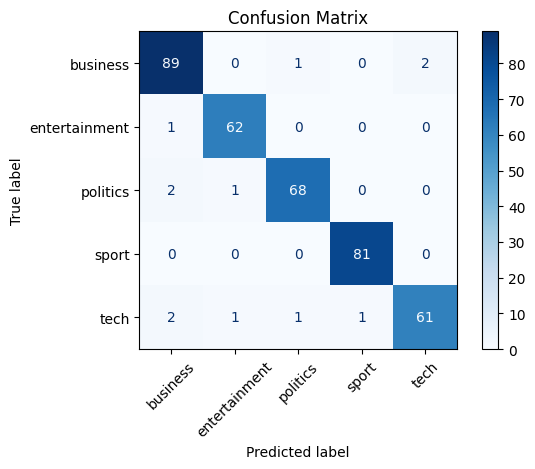

In [268]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# 1. Get predictions
y_pred = pipeline.predict(X_test)

# 2. Convert multi-label format to class indices for visualization
y_true_labels = np.argmax(y_test, axis=1)
y_pred_labels = np.argmax(y_pred, axis=1)

# 3. Generate confusion matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)

# 4. Plot with class names
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=mlb.classes_  # Use your actual class names
)
disp.plot(
    cmap='Blues',
    values_format='d',  # Integer format
    xticks_rotation=45  # Rotate labels for readability
)
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

In [269]:
from xgboost import XGBClassifier
from sklearn.multioutput import MultiOutputClassifier
pipeline.steps[-1] = ('clf', MultiOutputClassifier(
    XGBClassifier(
        objective='binary:logistic',
        n_estimators=100,
        tree_method='hist',
        random_state=42
    )
))

In [270]:
pipeline

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.8, max_features=5000, min_df=10,
                                 ngram_range=(1, 2), stop_words='english',
                                 sublinear_tf=True)),
                ('normalizer', Normalizer()),
                ('clf',
                 MultiOutputClassifier(estimator=XGBClassifier(base_score=None,
                                                               booster=None,
                                                               callbacks=None,
                                                               colsample_bylevel=None,
                                                               colsample_bynode=None,
                                                               colsample_bytree=None,
                                                               device=None,
                                                               early_s...
                                                               feature_weights=None,
                                                               gamma=None,
                                                               grow_policy=None,
                                                               importance_type=None,
                                                               interaction_constraints=None,
                                                               learning_rate=None,
                                                               max_bin=None,
                                                               max_cat_threshold=None,
                                                               max_cat_to_onehot=None,
                                                               max_delta_step=None,
                                                               max_depth=None,
                                                               max_leaves=None,
                                                               min_child_weight=None,
                                                               missing=nan,
                                                               monotone_constraints=None,
                                                               multi_strategy=None,
                                                               n_estimators=100,
                                                               n_jobs=None,
                                                               num_parallel_tree=None, ...)))])

We can see the training accuracy is low like 0.3

Training XGBoost model...
Training complete!

=== Evaluation Metrics ===
Train Accuracy: 0.9803
Test Accuracy: 0.8874
Micro F1: 0.9786
Macro F1: 0.9784


<Figure size 1000x800 with 0 Axes>

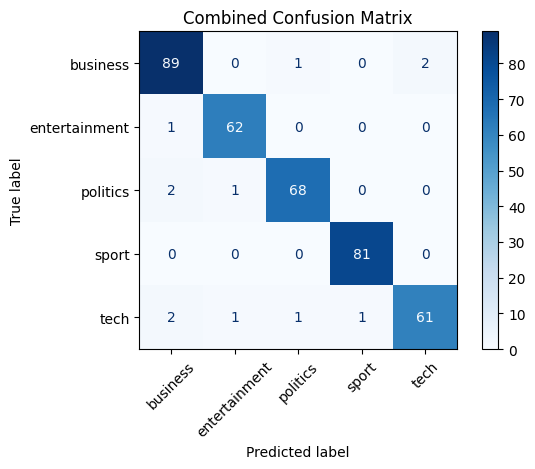

In [271]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multioutput import MultiOutputClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (accuracy_score, hamming_loss, 
                           f1_score, confusion_matrix, 
                           ConfusionMatrixDisplay)

# 1. Rebuild the entire pipeline (don't just replace steps)
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=5000,
        ngram_range=(1, 2),
        stop_words='english'
    )),
    ('clf', MultiOutputClassifier(
    XGBClassifier(
        objective='binary:logistic',
        n_estimators=150,  # Increased from 100
        max_depth=5,       # Reduced from default 6
        learning_rate=0.05, # Reduced from default 0.1
        subsample=0.8,      # Stochastic sampling
        colsample_bytree=0.8,
        reg_alpha=1,       # L1 regularization
        reg_lambda=1,      # L2 regularization
        tree_method='hist',
        random_state=42
    )
    ))
])

# 2. Train the model (required after pipeline modification)
print("Training XGBoost model...")
pipeline.fit(X_train, y_train)  # Make sure X_train and y_train are defined
print("Training complete!")

# 3. Generate predictions
y_pred_test = pipeline.predict(X_test)
y_pred_train = pipeline.predict(X_train)
# 4. Enhanced Evaluation Metrics
print("\n=== Evaluation Metrics ===")
print(f"Train Accuracy: {accuracy_score(y_train, y_pred_train):.4f}")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred_test):.4f}")
print(f"Micro F1: {f1_score(y_test, y_pred, average='micro'):.4f}")
print(f"Macro F1: {f1_score(y_test, y_pred, average='macro'):.4f}")

# 5. Combined Confusion Matrix
y_true_labels = np.argmax(y_test, axis=1)
y_pred_labels = np.argmax(y_pred, axis=1)

plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true_labels, y_pred_labels)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=mlb.classes_
)
disp.plot(
    cmap='Blues',
    values_format='d',
    xticks_rotation=45
)
plt.title("Combined Confusion Matrix")
plt.tight_layout()
plt.show()

Since both test and training accuracy for training and testing models are very close, so I can assume they don't have overfitting issue.
I also splited the dataset like 25% for the testing(or validation here).

Now,let's use the supervisor method for the kaggle competition

In [272]:
df = pd.read_csv('data/bbc/BBC News Test.csv')
df.head()

,ArticleId,Text
0,1018,qpr keeper day heads for preston queens park r...
1,1319,software watching while you work software that...
2,1138,d arcy injury adds to ireland woe gordon d arc...
3,459,india s reliance family feud heats up the ongo...
4,1020,boro suffer morrison injury blow middlesbrough...


In [273]:
df

,ArticleId,Text
0,1018,qpr keeper day heads for preston queens park r...
1,1319,software watching while you work software that...
2,1138,d arcy injury adds to ireland woe gordon d arc...
3,459,india s reliance family feud heats up the ongo...
4,1020,boro suffer morrison injury blow middlesbrough...
...,...,...
730,1923,eu to probe alitalia state aid the european ...
731,373,u2 to play at grammy awards show irish rock ba...
732,1704,sport betting rules in spotlight a group of mp...
733,206,alfa romeos to get gm engines fiat is to sto...


In [274]:
categories

,business,entertainment,politics,sport,tech
0,1,0,0,0,0
1,1,0,0,0,0
2,1,0,0,0,0
3,0,0,0,0,1
4,1,0,0,0,0
...,...,...,...,...,...
1485,0,1,0,0,0
1486,0,1,0,0,0
1487,1,0,0,0,0
1488,0,0,0,0,1


In [275]:
import pandas as pd

def process_data_with_ids(pipeline, new_df, text_column='Text', id_column='ArticleId'):
    """
    Process new DataFrame and return only ArticleId, Text, and PredictedLabel.
    
    Args:
        pipeline: Trained sklearn pipeline
        new_df: DataFrame containing text data and article IDs
        text_column: Name of text column (default: 'Text')
        id_column: Name of ID column (default: 'ArticleId')
    
    Returns:
        DataFrame with columns: ArticleId, Text, PredictedLabel
    """
    try:
        # Extract texts and IDs
        texts = new_df[text_column].values
        article_ids = new_df[id_column].values
        
        # Get predicted labels (directly as strings if possible)
        predicted_labels = pipeline.predict(texts)
        
        labels = np.array(['business', 'entertainment', 'politics', 'sport', 'tech'])

        # Find the index of the maximum value in each row (which is 1 in one-hot encoding)
        max_indices = np.argmax(predicted_labels, axis=1)

        # Get the corresponding labels
        label_names = labels[max_indices]

        # Reshape to have each label in its own array
        result = label_names.reshape(-1, 1)

        predicted_labels = np.ravel(result) 

        # Create simplified results DataFrame
        results = pd.DataFrame({
            'ArticleId': article_ids,
            #'Text': texts,
            'Category': predicted_labels
        })
        
        return results
    
    except Exception as e:
        print(f"Processing failed: {str(e)}")
        return None

In [276]:
[]

[]

In [277]:
results_df = process_data_with_ids(pipeline, df)

In [278]:
categories

,business,entertainment,politics,sport,tech
0,1,0,0,0,0
1,1,0,0,0,0
2,1,0,0,0,0
3,0,0,0,0,1
4,1,0,0,0,0
...,...,...,...,...,...
1485,0,1,0,0,0
1486,0,1,0,0,0
1487,1,0,0,0,0
1488,0,0,0,0,1


In [279]:
results_df

,ArticleId,Category
0,1018,business
1,1319,tech
2,1138,sport
3,459,business
4,1020,sport
...,...,...
730,1923,business
731,373,entertainment
732,1704,business
733,206,business


In [280]:
results_df.to_csv('output.csv', index=False)

Section 2

In [281]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
from sklearn.model_selection import train_test_split
from scipy.sparse import coo_matrix, csr_matrix
from scipy.spatial.distance import jaccard, cosine 
from pytest import approx


In [282]:
MV_users = pd.read_csv('data3/users.csv')
MV_movies = pd.read_csv('data3/movies.csv')
train = pd.read_csv('data3/train.csv')
test = pd.read_csv('data3/test.csv')

In [283]:
from collections import namedtuple

Data = namedtuple('Data', ['users','movies','train','test'])
data = Data(MV_users, MV_movies, train, test)

In [284]:
print("Users Info:")
print(data.users.head())
print("\nMovies Info:")
print(data.movies.head())
print("\nTrain Info:")
print(data.train.head())
print("\nTest Info:")
print(data.test.head())

Users Info:
   uID gender  age  accupation    zip
0    1      F    1          10  48067
1    2      M   56          16  70072
2    3      M   25          15  55117
3    4      M   45           7  02460
4    5      M   25          20  55455

Movies Info:
   mID                        title  year  Doc  Com  Hor  Adv  Wes  Dra  Ani  \
0    1                    Toy Story  1995    0    1    0    0    0    0    1   
1    2                      Jumanji  1995    0    0    0    1    0    0    0   
2    3             Grumpier Old Men  1995    0    1    0    0    0    0    0   
3    4            Waiting to Exhale  1995    0    1    0    0    0    1    0   
4    5  Father of the Bride Part II  1995    0    1    0    0    0    0    0   

   ...  Chi  Cri  Thr  Sci  Mys  Rom  Fil  Fan  Act  Mus  
0  ...    1    0    0    0    0    0    0    0    0    0  
1  ...    1    0    0    0    0    0    0    1    0    0  
2  ...    0    0    0    0    0    1    0    0    0    0  
3  ...    0    0    0    0   

In [285]:
import numpy as np
import pandas as pd
from sklearn.decomposition import NMF
from sklearn.metrics import mean_squared_error

# Prepare the rating matrix (users x movies)
def create_rating_matrix(df, n_users, n_movies):
    matrix = np.zeros((n_users, n_movies))
    for _, row in df.iterrows():
        uID = row['uID'] - 1  # converting to 0-based index
        mID = row['mID'] - 1
        rating = row['rating']
        matrix[uID, mID] = rating
    return matrix

# Assuming we know the number of users and movies from the data
n_users = data.users['uID'].max()
n_movies = data.movies['mID'].max()

# Create train and test matrices
train_matrix = create_rating_matrix(data.train, n_users, n_movies)
test_matrix = create_rating_matrix(data.test, n_users, n_movies)

# Initialize and fit NMF model
n_components = 20  # number of latent factors
model = NMF(n_components=n_components, init='random', random_state=42)
W = model.fit_transform(train_matrix)  # User features
H = model.components_  # Movie features

# Predict ratings
predicted_matrix = np.dot(W, H)

# Calculate RMSE for test set
test_ratings = []
pred_ratings = []
for _, row in data.test.iterrows():
    uID = row['uID'] - 1
    mID = row['mID'] - 1
    test_ratings.append(train_matrix[uID, mID])
    pred_ratings.append(predicted_matrix[uID, mID])

rmse = np.sqrt(mean_squared_error(test_ratings, pred_ratings))
print(f"Test RMSE: {rmse:.4f}")

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Test RMSE: 1.2859


It looks like 1.2859 is still too high compairing to the one we got from the week3.